In [1]:
! nvidia-smi

Fri Aug  7 09:47:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!pip install torch==1.5.1+cu92 torchvision==0.6.1+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 604.8MB 30kB/s 
     |████████████████████████████████| 6.5MB 38.6MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [5]:
import warnings
warnings.filterwarnings('ignore')
import zipfile
from zipfile import ZipFile
from pathlib import Path
from time import time
from datetime import datetime 
from __future__ import print_function
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from PIL import Image
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import cv2
import pkgutil
import importlib
import os
import random
%matplotlib inline
%config IPCompleter.greedy=True
%reload_ext autoreload
import io
import skimage
from skimage.transform import resize
from itertools import groupby
from tqdm.auto import tqdm
import gc
import seaborn as sns
sns.set()
print('Pytorch version:', torch.__version__)

Pytorch version: 1.5.1+cu92


In [6]:
%%time
from zipfile import ZipFile
with ZipFile('/content/gdrive/My Drive/ThumbnailData.zip', mode='r') as input:
  input.extractall('.')

CPU times: user 1.87 s, sys: 1.43 s, total: 3.3 s
Wall time: 3.37 s


In [7]:
def prepare_data(root, classes):
  finaldata = []
  for i in range(len(classes)):
    path = root + '/' + classes[i] + '/'
    data_rec = [(path+file_name, i) for file_name in os.listdir(path)]
    finaldata.extend(data_rec) 
  random.shuffle(finaldata)
  return finaldata

In [8]:
class_list       = [0,1,2,3]
class_names_dict = {0:'FB', 1:'LQ', 2:'SQ', 3:'WD'}
class_names      = ['Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones']

In [9]:
dataset          = prepare_data('/content/Data',class_names)
print(f'Dataset Length:{len(dataset)}, Train Data length: {int(len(dataset)*0.7)},Test Data length: {int(len(dataset)*0.3)}')
train_len = int(len(dataset)*0.7)

Dataset Length:19318, Train Data length: 13522,Test Data length: 5795


In [10]:
# Copying the code from github to colab
os.chdir('/content/')
!git clone https://github.com/anilbhatt1/Deep_Learning_EVA4_Phase2

fatal: destination path 'Deep_Learning_EVA4_Phase2' already exists and is not an empty directory.


In [11]:
%cd '/content/Deep_Learning_EVA4_Phase2/S2_Mobilenet_QuadCopters_Lambda'
! ls

/content/Deep_Learning_EVA4_Phase2/S2_Mobilenet_QuadCopters_Lambda
EVA4P2_S2_MobilenetV2_V1.ipynb	   README.md
EVA4P2_S2_MobilenetV2_V2.ipynb	   src
EVA4P2_S2_MobilenetV2_V3.ipynb	   Understanding_1.txt
EVA4P2_S2_MobilenetV2_V4.ipynb	   Weights
EVA4P2_S2_zip_file_creation.ipynb


In [12]:
os.chdir('/content/Deep_Learning_EVA4_Phase2/S2_Mobilenet_QuadCopters_Lambda/')
import src
from src.dataset import datatransforms as dtf
from src.dataset import customdataset as cds
from src.dataset import Alb_data_transforms as Alb
from src.losses  import Train_Losses
from src.losses  import Test_Losses

In [13]:
import albumentations as A
channel_means  = (0.48043839, 0.44820218, 0.39760034)
channel_stdevs = (0.27698959, 0.26908774, 0.28216029)
# Train Phase transformations
train_transforms = Alb.Albumentations_transform([
                                      A.Rotate((-30.0, 30.0)),
                                      A.HorizontalFlip(),
                                      A.Resize(224, 224),
                                      A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                      A.Normalize(mean=channel_means, std=channel_stdevs),
                                      A.Cutout(num_holes=1, max_h_size=56, max_w_size=56), # fillvalue is 0 after normalizing as mean is 0
                                    ])

#fillmeans = (np.array(channel_means)).astype(np.uint8)

# Test Phase transformations
test_transforms = Alb.Albumentations_transform([A.Resize(224, 224),
                                                A.Normalize(mean=channel_means, std=channel_stdevs),])

In [14]:
train = cds.Customdataset(dataset[:train_len],train_transforms)
test  = cds.Customdataset(dataset[train_len:],test_transforms)
print(f'Train Length {len(train)}, Test Length {len(test)}')

Train Length 13522, Test Length 5796


In [15]:
train_loader  = DataLoader(train, batch_size = 32,shuffle = True, pin_memory = True)
test_loader   = DataLoader(test, batch_size = 32, shuffle = True, pin_memory = True)

In [16]:
def unnormalize(img):
  img = img.cpu().numpy().astype(dtype=np.float32)
  #print(img.shape)
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i]) + channel_means[i]
  return np.transpose(img, (1,2,0))

In [17]:
dataiter = iter(train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


To check if images are coming out correctly as batches, images.shape: torch.Size([32, 3, 224, 224]), labels.shape: torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


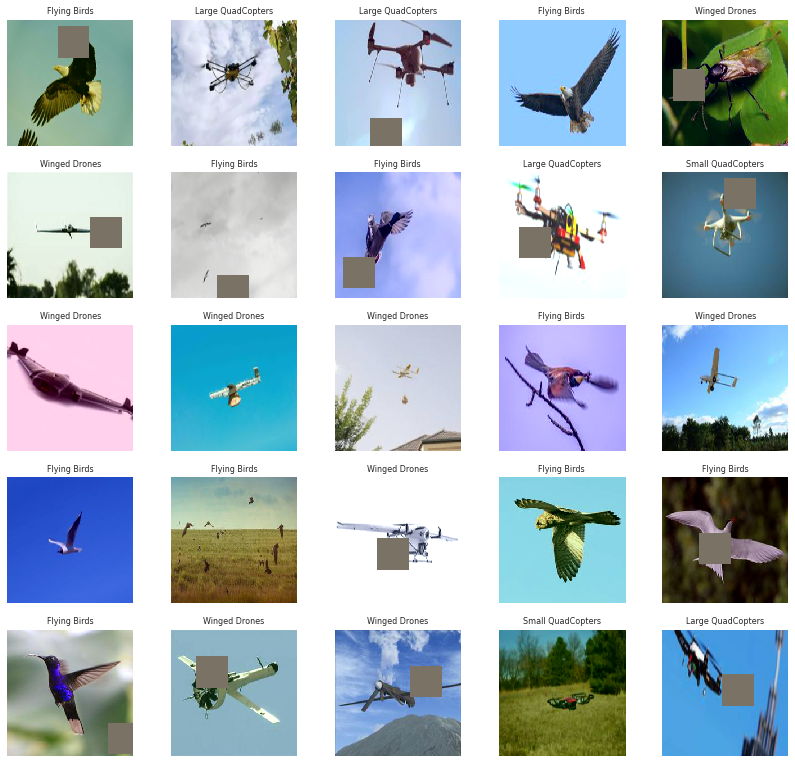

In [18]:
images, labels = dataiter.next()
print(f'To check if images are coming out correctly as batches, images.shape: {images.shape}, labels.shape: {labels.shape}')
num_classes = len(class_names)
r, c = 5, 5
fig = plt.figure(figsize=(14,14))
fig.subplots_adjust(hspace=0.01, wspace=0.3)
for i in range(r):
  for j in range(c):
    idx = i*c + j
    ax  = plt.subplot(r,c, idx + 1)
    ax.set_title(class_names[labels[idx]][:30], fontdict={'fontsize':8})
    plt.axis('off')
    ax.imshow(unnormalize(images[idx]), interpolation ='none')
plt.show()    

### Downloading Pretrained Mobilenet_V2 and displaying summary to understand the layers & corresponding parms

In [19]:
!pip install torchsummary
from torchsummary import summary
model = torch.hub.load('pytorch/vision:v0.6.0','mobilenet_v2',pretrained=True)
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
summary(model, input_size=(3, 224, 224))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

### Unfreezing only selected layers. Also customizing the FC layer to predict only 4 classes instead of 1000 classes (Mobilenet V2 is pretrained against imagenet which has 1000 classes)

In [20]:
for param in model.parameters():
    param.requires_grad = False

model.classifier[1] = torch.nn.Linear(in_features=model.classifier[1].in_features, out_features=4).to("cuda")
model.features[16].requires_grad  = True
model.features[17].requires_grad  = True
model.features[18].requires_grad  = True
model.classifier[0].requires_grad = True
model.classifier[1].requires_grad = True

### Displaying Layerwise view to understand convolutions, BN, Relu etc. coming under each layer. Will help us to reach a decision in which layer to unfreeze

In [21]:
model.to(model.device)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [22]:
train_loss = Train_Losses.Train_loss()
test_loss  = Test_Losses.Test_loss()

### Displaying layer names against model. Will help us to customize/ unfreeze/ freeze selected layers

In [23]:
for name, module in model.named_modules():
    print('name:',name)

name: 
name: features
name: features.0
name: features.0.0
name: features.0.1
name: features.0.2
name: features.1
name: features.1.conv
name: features.1.conv.0
name: features.1.conv.0.0
name: features.1.conv.0.1
name: features.1.conv.0.2
name: features.1.conv.1
name: features.1.conv.2
name: features.2
name: features.2.conv
name: features.2.conv.0
name: features.2.conv.0.0
name: features.2.conv.0.1
name: features.2.conv.0.2
name: features.2.conv.1
name: features.2.conv.1.0
name: features.2.conv.1.1
name: features.2.conv.1.2
name: features.2.conv.2
name: features.2.conv.3
name: features.3
name: features.3.conv
name: features.3.conv.0
name: features.3.conv.0.0
name: features.3.conv.0.1
name: features.3.conv.0.2
name: features.3.conv.1
name: features.3.conv.1.0
name: features.3.conv.1.1
name: features.3.conv.1.2
name: features.3.conv.2
name: features.3.conv.3
name: features.4
name: features.4.conv
name: features.4.conv.0
name: features.4.conv.0.0
name: features.4.conv.0.1
name: features.4.c

#### Function to calculate class-wise accuracy

In [24]:
def calc_classwiseacc(total_cnt,correct_cnt):
    class_test_acc = []
    epsilon    = 1e-10                     # To avoid division by zero incase not a single image showed up for a particular class
    for i in range(len(class_list)):
        correct_class   =  total_class = 0
        correct_class   =  correct_cnt.get(class_list[i])
        total_class     =  total_cnt.get(class_list[i])
        total_class     += epsilon
        class_accuracy  =  round((correct_class/total_class *100), 2)
        class_test_acc.append(class_accuracy)
        print ('Test accuracy for class - ', class_list[i], ' - ', class_names_dict.get(class_list[i]), ' : ', class_accuracy, \
               'correct:',correct_class, 'Total:',int(total_class) )
    
    print('Total Test Images:',sum(total_cnt.values()),'Correct Images:',sum(correct_cnt.values()) )

    return class_test_acc

#### Command to load the model from saved GPU model weights from previous training.

In [63]:
#path = f'/content/gdrive/My Drive/EVA4P2_S2_Weights/Mobilenet_V2_Stable_0730V3.pt'
#model.load_state_dict(torch.load(path))
path_stable_save = f'/content/gdrive/My Drive/EVA4P2_S2_Weights/Mobilenet_V2_Stable_0807V1.pt'
model = torch.jit.load(path_stable_save)

#### Train & Test for fixed epochs. Will save the model in 2 situations:
#### 1) When LR reduces based on ReduceLROnPlateau 
#### 2) On final Epoch. 
#### We are using 'torch.jit.save' instead of 'torch.save' as former is compatible with any of the mobile platforms - not just python (dynamically typed) can run even in platforms built in C which is statically typed programming languages

In [27]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import OneCycleLR

EPOCH         = 20
L2_factor     = 0.0001
L1_factor     = 0.0005
least_loss_lr = 0.03

train_loss_all = []
train_acc_all  = []
test_loss_all  = []
test_acc_all   = []
classwise_acc  = []
class_acc_all  = []
prev_lr_value  = least_loss_lr

OPTIMIZER = optim.SGD(model.parameters(),lr=least_loss_lr, momentum=0.9, weight_decay=L2_factor)
SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode='min',factor=0.1, min_lr=1e-10, patience =4, verbose=True)
criterion = nn.CrossEntropyLoss()
path_stable_save = f'/content/gdrive/My Drive/EVA4P2_S2_Weights/Mobilenet_V2_Stable_GPU_0807V1.pt'
path_final_save  = f'/content/gdrive/My Drive/EVA4P2_S2_Weights/Mobilenet_V2_Final_CPU_0807V1.pt'

for epoch in range(EPOCH):
  print('\nEPOCH:', epoch)
  train_losses, train_acc, lr_value = train_loss.train_loss_calc(model,model.device,train_loader=train_loader,optimizer=OPTIMIZER,
                                                       epoch=EPOCH, factor=L1_factor,criterion=criterion,
                                                       scheduler=SCHEDULER,print_idx=0,maxlr=0.2)
  test_losses, test_acc, wrong_predict, predicted_class, actual_class, label_total, label_correct, correct_predict, correct_pred_class, correct_act_class = \
                            test_loss.test_loss_calc(model,model.device,test_loader=test_loader,optimizer=OPTIMIZER,
                                                     total_epoch=EPOCH,current_epoch=epoch,criterion=criterion,
                                                     scheduler=SCHEDULER) 
  train_loss_all.extend(train_losses)
  train_acc_all.extend(train_acc)
  test_loss_all.extend(test_losses)
  test_acc_all.extend(test_acc)
  
  loss_decrease = 0  
  if len(test_loss_all) > 1:    
     loss_decrease = test_loss_all[-2] - test_loss_all[-1]
     if loss_decrease > 0:
        print(f'Test Loss -> Decreasing, Prev Loss:{test_loss_all[-2]:.6f}, Latest Loss:{test_loss_all[-1]:.6f}, Delta:{loss_decrease:.6f}')
     else:
        print(f'Test Loss -> Increasing, Prev Loss:{test_loss_all[-2]:.6f}, Latest Loss:{test_loss_all[-1]:.6f}, Delta:{loss_decrease:.6f}')

  if lr_value < prev_lr_value or epoch == int(EPOCH*0.8):           ### Keep the model in Gpu & Save the model values if loss values stabilized significantly
     script_module = torch.jit.script(model)      
     torch.jit.save(script_module, path_stable_save)
     print(f' **** Model Stable, hence Saved in epoch:{epoch} Prev Lr:{prev_lr_value} New Lr:{lr_value}:{path_stable_save}')  
  
  prev_lr_value = lr_value

  if epoch == (EPOCH -1):              ### Convert the model to CPU & save the model values on final epoch
     model.to('cpu')
     model.eval()
     traced_model = torch.jit.trace(model,torch.randn(1,3,244,244))      
     traced_model.save(path_final_save)    
     print(f' **** Model Saved in Final epoch:{epoch} Lr Value:{lr_value} :{path_final_save}')

     classwise_acc = calc_classwiseacc(label_total,label_correct)
     class_acc_all.append(classwise_acc)  

  0%|          | 0/423 [00:00<?, ?it/s]


EPOCH: 0


Train Loss = 2.3995625972747803 Batch Id = 422 Train Acc = 72.27 LR =0.030000: 100%|██████████| 423/423 [01:32<00:00,  4.58it/s]
  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Test Accuracy: 80.92, LR : 0.030000

EPOCH: 1


Train Loss = 2.4152190685272217 Batch Id = 422 Train Acc = 72.37 LR =0.030000: 100%|██████████| 423/423 [01:32<00:00,  4.56it/s]
  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0566, Test Accuracy: 73.67, LR : 0.030000
Test Loss -> Increasing, Prev Loss:0.031695, Latest Loss:0.056583, Delta:-0.024888

EPOCH: 2


Train Loss = 1.273785948753357 Batch Id = 422 Train Acc = 72.51 LR =0.030000: 100%|██████████| 423/423 [01:31<00:00,  4.62it/s]
  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0339, Test Accuracy: 80.21, LR : 0.030000
Test Loss -> Decreasing, Prev Loss:0.056583, Latest Loss:0.033905, Delta:0.022678

EPOCH: 3


Train Loss = 1.6793028116226196 Batch Id = 422 Train Acc = 72.19 LR =0.030000: 100%|██████████| 423/423 [01:32<00:00,  4.57it/s]
  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0369, Test Accuracy: 79.02, LR : 0.030000
Test Loss -> Increasing, Prev Loss:0.033905, Latest Loss:0.036917, Delta:-0.003012

EPOCH: 4


Train Loss = 2.20658802986145 Batch Id = 422 Train Acc = 72.39 LR =0.030000: 100%|██████████| 423/423 [01:30<00:00,  4.67it/s]
  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0754, Test Accuracy: 74.00, LR : 0.030000
Test Loss -> Increasing, Prev Loss:0.036917, Latest Loss:0.075426, Delta:-0.038509

EPOCH: 5


Train Loss = 3.3039708137512207 Batch Id = 422 Train Acc = 72.15 LR =0.030000: 100%|██████████| 423/423 [01:32<00:00,  4.58it/s]
  0%|          | 0/423 [00:00<?, ?it/s]

Epoch     6: reducing learning rate of group 0 to 3.0000e-03.

Test set: Average loss: 0.0348, Test Accuracy: 79.61, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.075426, Latest Loss:0.034788, Delta:0.040639

EPOCH: 6


Train Loss = 2.103870391845703 Batch Id = 422 Train Acc = 75.64 LR =0.003000: 100%|██████████| 423/423 [01:32<00:00,  4.57it/s]



Test set: Average loss: 0.0254, Test Accuracy: 81.04, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.034788, Latest Loss:0.025423, Delta:0.009365


  0%|          | 0/423 [00:00<?, ?it/s]

 **** Model Stable, hence Saved in epoch:6 Prev Lr:0.03 New Lr:0.003:/content/gdrive/My Drive/EVA4P2_S2_Weights/Mobilenet_V2_Stable_GPU_0807V1.pt

EPOCH: 7


Train Loss = 1.84620201587677 Batch Id = 422 Train Acc = 75.57 LR =0.003000: 100%|██████████| 423/423 [01:32<00:00,  4.58it/s]
  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Test Accuracy: 80.09, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.025423, Latest Loss:0.024345, Delta:0.001079

EPOCH: 8


Train Loss = 3.1285903453826904 Batch Id = 422 Train Acc = 75.69 LR =0.003000: 100%|██████████| 423/423 [01:32<00:00,  4.57it/s]
  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Test Accuracy: 81.83, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.024345, Latest Loss:0.019987, Delta:0.004358

EPOCH: 9


Train Loss = 0.616848886013031 Batch Id = 422 Train Acc = 75.60 LR =0.003000: 100%|██████████| 423/423 [01:31<00:00,  4.62it/s]
  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Test Accuracy: 82.25, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.019987, Latest Loss:0.018252, Delta:0.001735

EPOCH: 10


Train Loss = 1.8967045545578003 Batch Id = 422 Train Acc = 75.99 LR =0.003000: 100%|██████████| 423/423 [01:31<00:00,  4.65it/s]
  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Test Accuracy: 81.56, LR : 0.003000
Test Loss -> Increasing, Prev Loss:0.018252, Latest Loss:0.018353, Delta:-0.000101

EPOCH: 11


Train Loss = 0.9153656363487244 Batch Id = 422 Train Acc = 76.11 LR =0.003000: 100%|██████████| 423/423 [01:30<00:00,  4.66it/s]
  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Test Accuracy: 81.52, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.018353, Latest Loss:0.017655, Delta:0.000698

EPOCH: 12


Train Loss = 0.8735299706459045 Batch Id = 422 Train Acc = 76.38 LR =0.003000: 100%|██████████| 423/423 [01:30<00:00,  4.69it/s]
  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Test Accuracy: 82.57, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.017655, Latest Loss:0.016396, Delta:0.001258

EPOCH: 13


Train Loss = 0.7894479632377625 Batch Id = 422 Train Acc = 76.34 LR =0.003000: 100%|██████████| 423/423 [01:28<00:00,  4.77it/s]
  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Test Accuracy: 82.35, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.016396, Latest Loss:0.016076, Delta:0.000320

EPOCH: 14


Train Loss = 0.3045879602432251 Batch Id = 422 Train Acc = 76.48 LR =0.003000: 100%|██████████| 423/423 [01:30<00:00,  4.66it/s]
  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Test Accuracy: 82.44, LR : 0.003000
Test Loss -> Increasing, Prev Loss:0.016076, Latest Loss:0.016537, Delta:-0.000461

EPOCH: 15


Train Loss = 0.9494736194610596 Batch Id = 422 Train Acc = 76.73 LR =0.003000: 100%|██████████| 423/423 [01:30<00:00,  4.68it/s]
  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Test Accuracy: 80.62, LR : 0.003000
Test Loss -> Increasing, Prev Loss:0.016537, Latest Loss:0.017061, Delta:-0.000523

EPOCH: 16


Train Loss = 0.743120551109314 Batch Id = 422 Train Acc = 76.58 LR =0.003000: 100%|██████████| 423/423 [01:31<00:00,  4.60it/s]



Test set: Average loss: 0.0155, Test Accuracy: 82.59, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.017061, Latest Loss:0.015517, Delta:0.001543


  0%|          | 0/423 [00:00<?, ?it/s]

 **** Model Stable, hence Saved in epoch:16 Prev Lr:0.003 New Lr:0.003:/content/gdrive/My Drive/EVA4P2_S2_Weights/Mobilenet_V2_Stable_GPU_0807V1.pt

EPOCH: 17


Train Loss = 1.3890269994735718 Batch Id = 422 Train Acc = 76.79 LR =0.003000: 100%|██████████| 423/423 [01:29<00:00,  4.72it/s]
  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Test Accuracy: 80.47, LR : 0.003000
Test Loss -> Increasing, Prev Loss:0.015517, Latest Loss:0.017413, Delta:-0.001896

EPOCH: 18


Train Loss = 0.8516783118247986 Batch Id = 422 Train Acc = 76.43 LR =0.003000: 100%|██████████| 423/423 [01:30<00:00,  4.70it/s]
  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0152, Test Accuracy: 81.66, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.017413, Latest Loss:0.015205, Delta:0.002208

EPOCH: 19


Train Loss = 1.1198478937149048 Batch Id = 422 Train Acc = 76.82 LR =0.003000: 100%|██████████| 423/423 [01:30<00:00,  4.66it/s]



Test set: Average loss: 0.0148, Test Accuracy: 82.04, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.015205, Latest Loss:0.014814, Delta:0.000392
 **** Model Saved in Final epoch:19 Lr Value:0.003 :/content/gdrive/My Drive/EVA4P2_S2_Weights/Mobilenet_V2_Final_CPU_0807V1.pt
Test accuracy for class -  0  -  FB  :  97.31 correct: 2243 Total: 2305
Test accuracy for class -  1  -  LQ  :  77.84 correct: 871 Total: 1119
Test accuracy for class -  2  -  SQ  :  51.96 correct: 450 Total: 866
Test accuracy for class -  3  -  WD  :  79.08 correct: 1191 Total: 1506
Total Test Images: 5796 Correct Images: 4755


#### Plotting misclassified images received from last epoch. Will throw error message if misclassified images <25. In case of such an event adjust the subplots to suit the number of images to be plotted


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

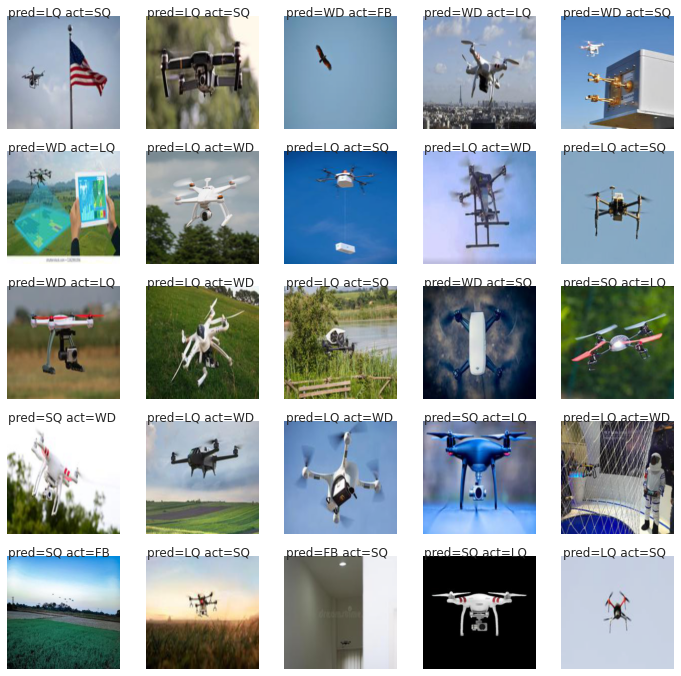

In [28]:
figure=plt.figure(figsize=(12,12))
if len(predicted_class) > 25: 
    for i in range(25):
      plt.subplot(5,5,i+1)
      plt.axis(False)
      plt.imshow(unnormalize(wrong_predict[i].cpu()),interpolation='bilinear')
      prediction = class_names_dict.get(predicted_class[i])
      actual     = class_names_dict.get(actual_class[i])
      s="pred="+str(prediction)+" act="+str(actual)
      plt.text(2,-1,s)
else:
  print('Less than 25 images:', len(predicted_class))

#### Plotting correctly classified images received from last epoch. Will throw error message if misclassified images <25. In case of such an event adjust the subplots to suit the number of images to be plotted

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

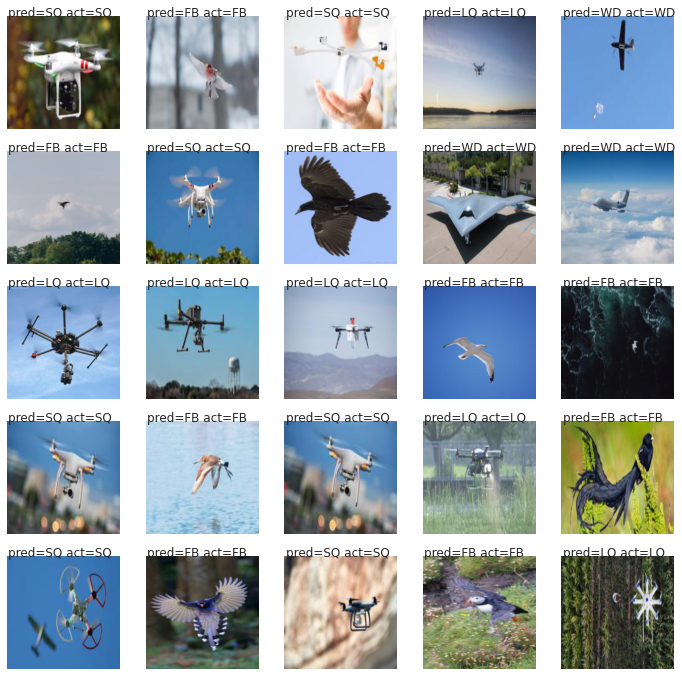

In [29]:
figure=plt.figure(figsize=(12,12))
if len(predicted_class) > 25: 
    for i in range(25):
      plt.subplot(5,5,i+1)
      plt.axis(False)
      plt.imshow(unnormalize(correct_predict[i].cpu()),interpolation='bilinear')
      prediction = class_names_dict.get(correct_pred_class[i])
      actual     = class_names_dict.get(correct_act_class[i])
      s="pred="+str(prediction)+" act="+str(actual)
      plt.text(2,-1,s)
else:
  print('Less than 25 images:', len(predicted_class))

#### Train & Test accuracies, Test Losses & Train Losses

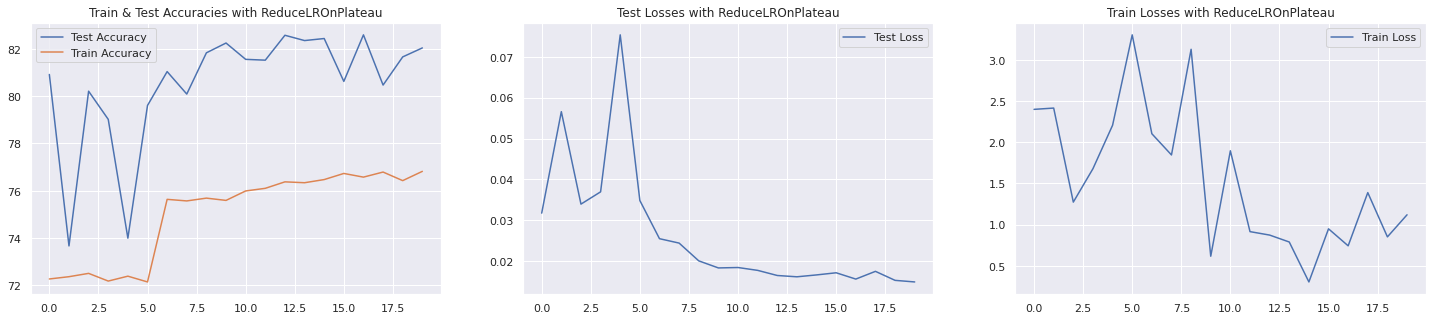

In [30]:
figure = plt.figure(figsize=(25,5))
labels = ['With L1=0.0001 & L2=0.0005']

plt.subplot(1,3,1)
plt.title("Train & Test Accuracies with ReduceLROnPlateau")
plt.plot(test_acc_all,label='Test Accuracy')
plt.plot(train_acc_all,label='Train Accuracy')
plt.legend(loc="best")

plt.subplot(1,3,2)
plt.title("Test Losses with ReduceLROnPlateau")
plt.plot(test_loss_all,label='Test Loss')
plt.legend(loc="best")

plt.subplot(1,3,3)
plt.title("Train Losses with ReduceLROnPlateau")
plt.plot(train_loss_all,label='Train Loss')
plt.legend(loc="best")